# Big Data Aplicado - Práctica 2 - Hadoop+Sqoop+Hive

Con Sqoop, a partir de una base de datos MySQL, se cargan unas tablas en HDFS y su salida la cargarmos en Hive con Spark, para finalmente transformarse dentro de Hive.

## Instalación de herramientas

### Instalación de Hadoop

Descargamos Hadoop, descomprimimos y movemos a la carpeta de programas.

In [1]:
%%bash
wget -q https://downloads.apache.org/hadoop/common/hadoop-3.3.1/hadoop-3.3.1.tar.gz
tar -xzf hadoop-3.3.1.tar.gz
mv hadoop-3.3.1/ /usr/local/

Creamos las variables de entorno necesarias.

In [8]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64/"
os.environ["PATH"] = os.environ["PATH"] + ":" + "/usr/local/hadoop-3.3.1/bin"

### Instalación de Sqoop

Descargamos Sqoop, descomprimimos y movemos a la carpeta de programas.


In [3]:
%%bash 
wget -q http://archive.apache.org/dist/sqoop/1.4.7/sqoop-1.4.7.bin__hadoop-2.6.0.tar.gz
tar -xf sqoop-1.4.7.bin__hadoop-2.6.0.tar.gz
mv sqoop-1.4.7.bin__hadoop-2.6.0 /usr/local/sqoop 

Descargamos librerías necesarias, descomprimimos y movemos a la carpeta de las librerías de Sqoop.

In [4]:
%%bash
wget -q https://dlcdn.apache.org//commons/lang/binaries/commons-lang-2.6-bin.tar.gz
tar -xf commons-lang-2.6-bin.tar.gz
mv /content/commons-lang-2.6/commons-lang-2.6.jar /usr/local/sqoop/lib

Creamos las variables de entorno necesarias.

In [9]:
import os
os.environ["HADOOP_HOME"] = "/usr/local/hadoop-3.3.1"
os.environ["HADOOP_COMMON_HOME"] = os.environ["HADOOP_HOME"] 
os.environ["HADOOP_MAPRED_HOME"] = os.environ["HADOOP_HOME"]
os.environ["SQOOP_HOME"] = "/usr/local/sqoop"
os.environ["PATH"] = os.environ["PATH"] + ":" + "/usr/local/sqoop/bin" 
os.environ["HADOOP_COMMON_LIB_NATIVE_DIR"] = os.environ["HADOOP_HOME"] + "/lib/native"
os.environ["CLASSPATH"] = "/content/tmp"
# variables de partes no instaladas pero que sqoop busca (eliminar warnings)
os.environ["HBASE_HOME"] = os.environ["HADOOP_HOME"]
os.environ["HCAT_HOME"] = os.environ["HADOOP_HOME"]
os.environ["ACCUMULO_HOME"] = os.environ["HADOOP_HOME"]
os.environ["ZOOKEEPER_HOME"] = os.environ["HADOOP_HOME"]

Comprobamos que se ha instalado correctamente Hadoop y Sqoop viendo la versión de Sqoop.

In [10]:
!sqoop-version

2022-05-05 16:47:13,954 INFO sqoop.Sqoop: Running Sqoop version: 1.4.7
Sqoop 1.4.7
git commit id 2328971411f57f0cb683dfb79d19d4d19d185dd8
Compiled by maugli on Thu Dec 21 15:59:58 STD 2017


Para completar la instalación, es necesario que tengamos la librería de conexión java para que Sqoop vea la base de datos MySQL de la que descargaremos los datos.<br>
Descargamos la librería, descomprimimos y copiamos en la carpeta de librerías de Sqoop.

In [7]:
%%bash
wget -q http://ftp.ntu.edu.tw/MySQL/Downloads/Connector-J/mysql-connector-java-5.1.49.tar.gz
tar -zxf mysql-connector-java-5.1.49.tar.gz
cd mysql-connector-java-5.1.49
cp mysql-connector-java-5.1.49-bin.jar /usr/local/sqoop/lib

### Instalación de Hive

MATERIAL EXTRA PROPIO<br>
En los repositorios de PIP se encuentra disponible la versión 3.2.1 o superior en caso de que cambie, que al instalarse desde dicho repositorio hace que se activen e instalen sus dependencias, por lo que no es necesario hacer la descarga desde *apache.org/spark*. Tampoco es necesario incluir las rutas especificas a los directorios de Spark.

Instalamos con `pip` la librería de Python.

In [8]:
!pip install pyspark

     |████████████████████████████████| 281.4 MB 36 kB/s 
     |████████████████████████████████| 198 kB 52.0 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=10a4182593779d69df5c403d556d533fc7dc2f5d51a93c5da49271e9142dfc22
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


## Ejecución de Sqoop

Sqoop va a conectarse a una base de datos en db4free.net que contiene los datos de una empresa con varias tiendas en la que vende productos electrónicos. A parte de las tiendas y los productos, se tiene almacenado una agrupación de la familia a la que pertenece el producto y también el stock que tiene cada tienda de cada uno de los productos.<br>
Las 4 tablas se encuentran relacionadas entre sí por claves foráneas.<br>

Gráficamente este es el esquema de la BBDD:
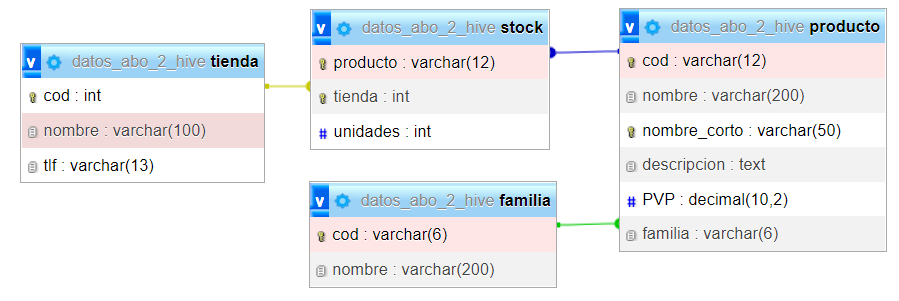

MATERIAL EXTRA PROPIO<br>
Se utiliza la opción `import-all-tables` en lugar de ir descargando una a una las tablas, y así hacer un todo en uno.

In [11]:
!sqoop import-all-tables \
   -Dmapreduce.job.user.classpath.first=true \
   --connect jdbc:mysql://db4free.net:3306/datos_abo_2_hive \
   --username abenoga --password "bda_pr_22" \
   --fields-terminated-by ';' \
   --m 1 \
   --bindir /usr/local/hadoop-3.3.1/etc/hadoop 

2022-05-05 16:47:28,352 INFO sqoop.Sqoop: Running Sqoop version: 1.4.7
2022-05-05 16:47:28,414 WARN tool.BaseSqoopTool: Setting your password on the command-line is insecure. Consider using -P instead.
2022-05-05 16:47:28,605 INFO manager.MySQLManager: Preparing to use a MySQL streaming resultset.
Thu May 05 16:47:34 UTC 2022 WARN: Establishing SSL connection without server's identity verification is not recommended. According to MySQL 5.5.45+, 5.6.26+ and 5.7.6+ requirements SSL connection must be established by default if explicit option isn't set. For compliance with existing applications not using SSL the verifyServerCertificate property is set to 'false'. You need either to explicitly disable SSL by setting useSSL=false, or set useSSL=true and provide truststore for server certificate verification.
2022-05-05 16:47:37,737 INFO tool.CodeGenTool: Beginning code generation
2022-05-05 16:47:37,760 INFO manager.SqlManager: Executing SQL statement: SELECT t.* FROM `familia` AS t LIMIT 1

## Ejecución de Hive

### Instanciando Hive

MATERIAL EXTRA PROPIO<br>
La creación de sesión en PySpark que aparece en los Colab del curso, está *deprecated* según el error que da al ejecutar el comando<br> 
`sqlContext =  SQLContext(sc)` -> `Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.`, por lo que generamos la sesión de PySpark según la [documentación de la versión 3.2.1](https://spark.apache.org/docs/latest/api/python/).

Cargamos la librería de `pyspark` necesaria e instanciamos una sesión de Spark con Hive.<br>
Además configuramos un directorio propio como contenedor de los datos en lugar del que se generaría por defecto, este directorio no es necesario que exista previamente.

In [12]:
from pyspark.sql import SparkSession

hiveCtx = SparkSession \
    .builder \
    .appName('Practica2_BDA_Sqoop_Hive') \
    .config("spark.sql.warehouse.dir", '/content/warehouse_tiendas') \
    .enableHiveSupport() \
    .getOrCreate()
hiveCtx

### Carga en tablas

Creamos en Hive una nueva tabla para *tienda*.

In [13]:
hiveCtx.sql("CREATE TABLE IF NOT EXISTS tienda \
              (cod INT, nombre STRING, tlf STRING) \
              USING hive \
              OPTIONS(fileFormat 'textfile', fieldDelim ';')")

DataFrame[]

Cargamos los datos provenientes de Sqoop del directorio *tienda* sobre la nueva tabla *tienda*.

In [14]:
hiveCtx.sql("LOAD DATA INPATH '/content/tienda/part*' INTO TABLE tienda")

DataFrame[]

Verificamos que los datos se han cargado en la tabla.

In [15]:
hiveCtx.sql("select * from tienda").show()

+---+---------+---------+
|cod|   nombre|      tlf|
+---+---------+---------+
|  1|  CENTRAL|600100100|
|  2|SUCURSAL1|600100200|
|  3|SUCURSAL2|     null|
+---+---------+---------+



Realizamos los mismos pasos para las otras 3 tablas: *familia*, *stock* y *producto*.

In [16]:
hiveCtx.sql("CREATE TABLE IF NOT EXISTS familia   \
              (cod STRING, nombre STRING) \
              USING hive \
              OPTIONS(fileFormat 'textfile', fieldDelim ';')")

DataFrame[]

In [17]:
hiveCtx.sql("LOAD DATA INPATH '/content/familia/part*' INTO TABLE familia")

DataFrame[]

In [18]:
hiveCtx.sql("select * from familia limit 4").show()

+------+-------------------+
|   cod|             nombre|
+------+-------------------+
|CAMARA|  Cámaras digitales|
|CONSOL|           Consolas|
| EBOOK|Libros electrónicos|
|IMPRES|         Impresoras|
+------+-------------------+



In [19]:
hiveCtx.sql("CREATE TABLE IF NOT EXISTS stock   \
              (producto STRING, tienda INT, unidades INT) \
              USING hive \
              OPTIONS(fileFormat 'textfile', fieldDelim ';')")

DataFrame[]

In [20]:
hiveCtx.sql("LOAD DATA INPATH '/content/stock/part*' INTO TABLE stock")

DataFrame[]

In [21]:
hiveCtx.sql("select * from stock limit 4").show()

+------------+------+--------+
|    producto|tienda|unidades|
+------------+------+--------+
|       3DSNG|     1|       2|
|       3DSNG|     2|       1|
|  ACERAX3950|     1|       1|
|ARCLPMP32GBN|     2|       1|
+------------+------+--------+



In [22]:
hiveCtx.sql("CREATE TABLE IF NOT EXISTS producto   \
              (cod STRING, descripcion STRING, familia STRING, \
               nombre STRING, nombre_corto STRING, PVP DECIMAL(10, 2)) \
              USING hive \
              OPTIONS(fileFormat 'textfile', fieldDelim ';')")

DataFrame[]

In [23]:
hiveCtx.sql("LOAD DATA INPATH '/content/producto/part*' INTO TABLE producto")

DataFrame[]

In [24]:
hiveCtx.sql("select * from producto limit 4").show()

+------------+--------------------+-------+------+--------------------+------+
|         cod|         descripcion|familia|nombre|        nombre_corto|   PVP|
+------------+--------------------+-------+------+--------------------+------+
|       3DSNG|Consola portátil ...| CONSOL|  null|  Nintendo 3DS negro|270.00|
|  ACERAX3950|Características: ...| ORDENA|  null|Acer AX3950 I5-65...|410.00|
|ARCLPMP32GBN|Características: ...|    MP3|  null|Archos Clipper MP...| 26.70|
|BRAVIA2BX400|Características: ...|     TV|  null|Sony Bravia 32IN ...|356.90|
+------------+--------------------+-------+------+--------------------+------+



Veamos las tablas que se han creado y cargado en el esquema.

In [25]:
hiveCtx.sql("show tables").show()

+---------+---------+-----------+
|namespace|tableName|isTemporary|
+---------+---------+-----------+
|  default|  familia|      false|
|  default| producto|      false|
|  default|    stock|      false|
|  default|   tienda|      false|
+---------+---------+-----------+



### Consultas/Transformaciones sobre Hive

Vamos a actualizar el precio, *PVP*, de la tabla *producto* en un 10%.<br>
Para ello realizaremos una consulta de prueba, para los productos que empiezan por la letra 'A', tanto al principio como al final del código, y así verificar la transformación.<br>
El contenido de la tabla *producto* lo cargaremos en memoria en un DataFrame de Spark, al cual le haremos la modificación del precio. Este DataFrame modificado lo guardaremos como una vista temporal, *precio_aumentado*.<br>
Para sobrescribir la tabla *producto* utilizaremos la vista *precio_aumentado*.<br>
Nota: no se realiza un *Update* directo sobre la tabla, porque Spark no soporta esta función.

In [26]:
hiveCtx.sql("select * from producto where cod like 'A%'").show()

precio = hiveCtx.sql("select * from producto")

precio.withColumn('PVP', precio['PVP']*1.1 ) \
      .createOrReplaceTempView('precio_aumentado')

hiveCtx.sql("INSERT OVERWRITE producto TABLE precio_aumentado;")

hiveCtx.sql("select * from producto where cod like 'A%'").show()

+------------+--------------------+-------+------+--------------------+------+
|         cod|         descripcion|familia|nombre|        nombre_corto|   PVP|
+------------+--------------------+-------+------+--------------------+------+
|  ACERAX3950|Características: ...| ORDENA|  null|Acer AX3950 I5-65...|410.00|
|ARCLPMP32GBN|Características: ...|    MP3|  null|Archos Clipper MP...| 26.70|
+------------+--------------------+-------+------+--------------------+------+

+------------+--------------------+-------+------+--------------------+------+
|         cod|         descripcion|familia|nombre|        nombre_corto|   PVP|
+------------+--------------------+-------+------+--------------------+------+
|  ACERAX3950|Características: ...| ORDENA|  null|Acer AX3950 I5-65...|451.00|
|ARCLPMP32GBN|Características: ...|    MP3|  null|Archos Clipper MP...| 29.37|
+------------+--------------------+-------+------+--------------------+------+



Generaremos ahora una tabla completamente nueva, a partir de datos del resto de tablas, agrupando alguno de ellos.<br>
Se quiere obtener todos los productos, con su familia y su precio, y conocer el número de productos que existen en total disponibles.<br>
Para conseguirlo uniremos las tablas:
+ *producto*, de donde tendrá de salida el código, el nombre y el precio.
+ *familia*, cuyo campo en la salida será el nombre de la familia.
+ *stock*, donde sumaremos todas las unidades disponibles.

Se realiza *join* entre las tablas, siendo la principal *producto* y recogiendo el dato correspondiente de las otras tablas. El resultado se agrupa por todos los campos para obtener la suma de la cantidad de producto de *stock*.

In [27]:
hiveCtx.sql("select p.cod codigo_producto \
                  , p.nombre_corto nombre_producto \
                  , f.nombre familia \
                  , p.PVP precio\
                  , sum(s.unidades) cantidad_productos\
            from producto p \
                 join familia f on p.familia=f.cod \
                 join stock s on p.cod=s.producto \
            group by 1,2,3,4 \
            ").write.saveAsTable('tabla_agrupada')

hiveCtx.sql("select * from tabla_agrupada limit 4").show()

+---------------+--------------------+--------------------+------+------------------+
|codigo_producto|     nombre_producto|             familia|precio|cantidad_productos|
+---------------+--------------------+--------------------+------+------------------+
|      LGM237WDP|LG TDT HD 23 M237...|         Televisores|204.60|                 1|
|   PBELLI810323|Packard Bell I810...|         Ordenadores|837.98|                 1|
|    SMSGCLX3175|     Samsung CLX3175|Equipos multifunción|209.00|                 1|
|   EEEPC1005PXD|Asus EEEPC 1005PX...|            Netbooks|269.94|                 3|
+---------------+--------------------+--------------------+------+------------------+



Vemos las tablas finales del esquema de Hive.<br>
Si estuviesemos en un entorno real de Hive, la vista temporal desaparecería al cerrar la sesión, quedándose las 5 tablas persistentes.

In [28]:
hiveCtx.sql("show tables").show()

+---------+----------------+-----------+
|namespace|       tableName|isTemporary|
+---------+----------------+-----------+
|  default|         familia|      false|
|  default|        producto|      false|
|  default|           stock|      false|
|  default|  tabla_agrupada|      false|
|  default|          tienda|      false|
|         |precio_aumentado|       true|
+---------+----------------+-----------+



---

## **Punto Extra de la Práctica:**
*¿Serías capaz de integrar esta práctica con la desarrollada en "Sistemas de Big Data"? Es decir, que cargues los datos "en bruto" de la fuente, los transformes para hacerlos procesables y que cargues el dataset, de modo que quede listo para, a partir de él, poder realizar los análisis pertinentes y la minería de datos oportuna. Documéntalo y justifica cómo lo harías.*

Sí, sería capaz.

Ya en esta práctica se han realizado cambios en una columna, como cuando se está haciendo tratamiento de datos.
```
precio.withColumn('PVP', precio['PVP']*1.1 )
```
También se podría aplicar el tratamiento de nulos en la tabla *productos*, ya que una de sus columnas tiene sus valores como *null*. Por lo que podría ser eliminada la columna.

Por tanto, es posible hacerlo, tanto guardando las tablas tal cual venga del origen y procesandolas posteriormente generando dataset/DataFrame nuevos, o haciendo el procesamiento entre Sqoop y la carga a Hive, dejando solo en Hive las tablas listas para el análisis y minería de datos.